## Course 1: Custom models, layers, and loss functions

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

### Branching model 
Models with more than one output allow us to make multiple predictions
given a single source of data.

A simple example is shown below

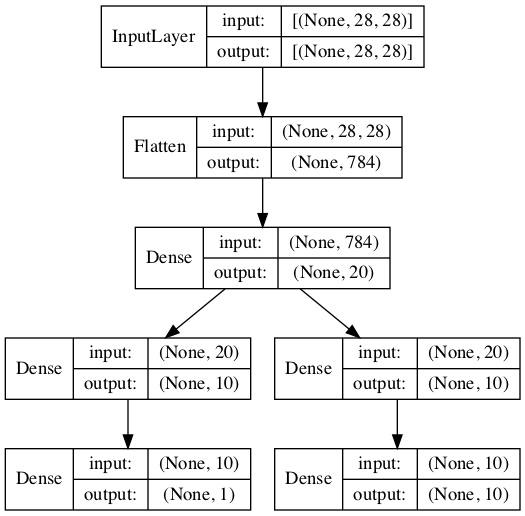

In [20]:
def build_branch_model():

    inputs = layers.Input(shape=(28,28))
    flatten = layers.Flatten()(inputs)
    dense = layers.Dense(20, activation='relu')(flatten)
    
    branch_1 = layers.Dense(10, activation='relu')(dense)
    branch_2 = layers.Dense(10, activation='relu')(dense)    
    
    output_1 = layers.Dense(1)(branch_1)
    output_2 = layers.Dense(10, activation='sigmoid')(branch_2)

    outputs = [output_1, output_2]

    model = tf.keras.Model(inputs, outputs)
    
    return model

branch_model = build_branch_model()
plot_model(branch_model, show_shapes=True, show_layer_names=False)

###### Get energy efficiency dataset from UCI

The following spreadsheet pulled from the UCI Machine Leaning archive 
contains building characteristings and their heating/cooling capabilities.

The features included are specifically:

    X1 Relative Compactness
    X2 Surface Area
    X3 Wall Area
    X4 Roof Area
    X5 Overall Height
    X6 Orientation
    X7 Glazing Area
    X8 Glazing Area Distribution
    y1 Heating Load
    y2 Cooling Load


We'll use this dataset to test the capabilities of our dual-output model defined above.


###### Load

In [35]:
import numpy as np
import pandas as pd

# Energy efficiency dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"

columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

data = pd.read_excel(url)
input_data = data[columns]
output_data = data[['Y1','Y2']]

###### Prepare data

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=.1)


# Scale
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Format
def format_outputs(df):
    y1 = df.pop('Y1').values
    y2 = df.pop('Y2').values
    return y1, y2

y_train = format_outputs(y_train)
y_test = format_outputs(y_test)

###### Train model with two target values

In [38]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

tf.keras.backend.clear_session()

def build_model():
    
    inputs = layers.Input(shape=(len(columns),))
    dense = layers.Dense(40, activation='relu')(inputs)
    
    branch_1 = layers.Dense(20, activation='relu')(dense)
    branch_2 = layers.Dense(20, activation='relu')(dense)    
    
    y1_output = layers.Dense(1, name='y1_output')(branch_1)
    y2_output = layers.Dense(1, name='y2_output')(branch_2)

    model = tf.keras.Model(inputs, [y1_output, y2_output])
    
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40)           360         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           820         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           820         dense[0][0]                      
______________________________________________________________________________________________

In [43]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=.001),
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [49]:
history = model.fit(X_train, y_train, 
                    batch_size=16, epochs=200,
                    validation_data=(X_test, y_test), verbose=0)

###### Visualize model performance

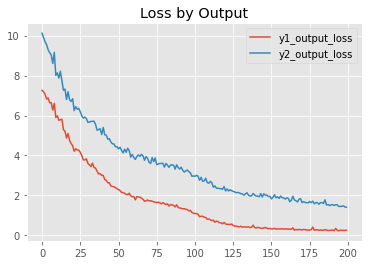

In [62]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.style.use('ggplot')
    hist = pd.DataFrame(history.history)
    hist[['y1_output_loss','y2_output_loss']].plot(title='Loss by Output')
    
plot_loss(history)

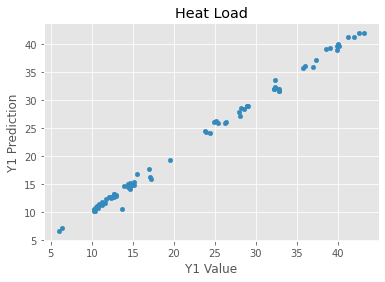

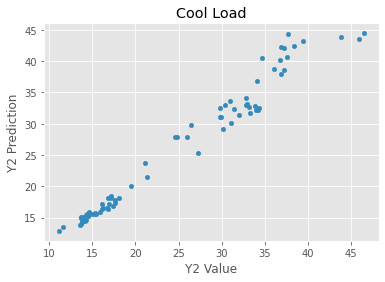

In [93]:
def plot_results(pred):
    
    y1_test, y2_test = y_test
    y1_pred = [x[0] for x in y_pred[0].tolist()]
    y2_pred = [x[0] for x in y_pred[1].tolist()]
    df = pd.DataFrame({'Y1 Value': y1_test, 'Y2 Value': y2_test,
                       'Y1 Prediction': y1_pred, 'Y2 Prediction': y2_pred})    
    df.plot.scatter(*['Y1 Value', 'Y1 Prediction'], title='Heat Load')
    df.plot.scatter(*['Y2 Value', 'Y2 Prediction'], title='Cool Load')


y_pred = model.predict(X_test)
plot_results(y_pred)

### Siamese Network for Fashion MNIST



The key steps making this possible are

- our model architechture routes two inputs through a base network
- we take the L2 norm between vector outputs from each base model

By using the distance between each image embedding as the model output, 
we can then create a loss function that allows this embedding to be learned
along with the representations corresponding to similarity.



###### Base network

We use a base network to create an embedding for each image. $\theta_b: x_i \rightarrow v_i$ 

The dimensionality of $v$ depends on the number of nodes in the final layer,
which is set by `output_shape` declared above the model initializer.

In our case, $v\in\mathbb{R}^{32}$


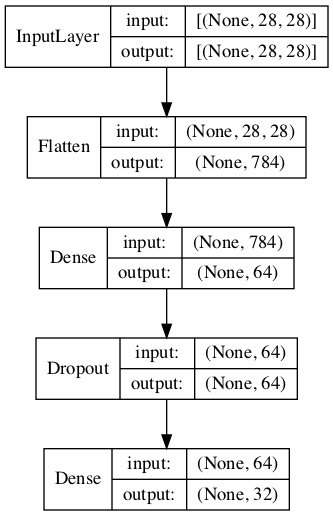

In [147]:
output_shape = 32

def initialize_base_network():
    
    input = layers.Input(shape=(28,28))
    x = layers.Flatten()(input)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(output_shape, activation='relu')(x)
    
    model = tf.keras.Model(input, x)
    return model

plot_model(initialize_base_network(), show_layer_names=False, show_shapes=True)

######  Siamese network



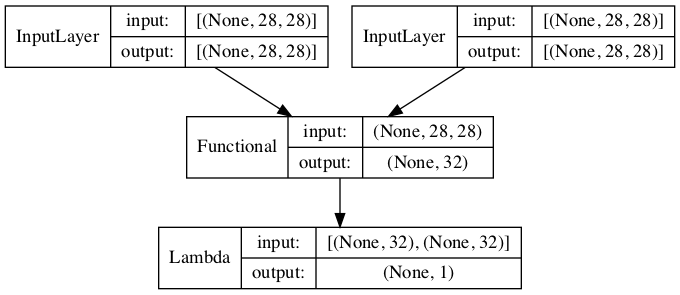

In [145]:
from keras import backend as K

def euclidean_distance(vectors):
    x, y = vectors
    sum_of_squared_difference = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_of_squared_difference, K.epsilon()))

def build_siamese_network_from_base():

    input_a = layers.Input(shape=(28,28))
    input_b = layers.Input(shape=(28,28))
    
    base_network = initialize_base_network()

    output_a = base_network(input_a)
    output_b = base_network(input_b)
    
    output = layers.Lambda(euclidean_distance, output_shape=output_shape)([output_a, output_b])
    model = tf.keras.Model([input_a, input_b], output)
    
    return model


model = build_siamese_network_from_base()

plot_model(model, show_layer_names=False, show_shapes=True)

###### Prepare data


Given two image tensors $x_i$ and $x_j$ with classes $y_i$ and $y_j$,
we can train a *siamese network* that takes in image pairs and outputs their similarity.

The inputs/targets used to train this network are $X$ and $Y$,

where $X = (x_i, x_j) \mid x_i,x_j \in Images $,

and $Y = \begin{cases} 0 &\mbox{if } y_i\neq y_j \\ 1 & \mbox{if } y_i \equiv y_j \end{cases} $

In [395]:
from tensorflow.keras.datasets import fashion_mnist

def create_dataset(dataset, ratio=.5):

    images, labels = dataset
    indices = np.arange(len(labels))
    original = np.stack([indices, labels], axis=1)
    shuffled = np.stack([indices, labels], axis=1)

    X, y = [], []

    # Get pairs of images w/ labels corresponding to their class similarity
    np.random.shuffle(shuffled)
    X.extend(np.stack([images, images[shuffled[:,0]]], axis=1))
    y.extend([int(u==v) for u, v in zip(labels, shuffled[:,1])])
    # Check if the class labels match for tuples of index/label pairs
    same_class = lambda tuples: tuples[0][1]==tuples[1][1]
    # While the classes are imbalanced (sum/len gives ratio for binary data)
    while sum(y) / len(y) < ratio:
        # Repeat process, adding only image pairs with matching classes
        np.random.shuffle(shuffled)
        image_pairs = [(data[index_label_pairs[0][0]], data[index_label_pairs[1][0]])
                       for index_label_pairs in filter(same_class, zip(original, shuffled))]
        X.extend(image_pairs)
        y.extend([1]*len(image_pairs))
    return np.array(X) / 255, np.array(y)

# Prepare train/test sets
train, test = fashion_mnist.load_data()
X_train, y_train = create_dataset(train)
X_validation, y_validation = create_dataset(test)

# This shuffles our data and gives us a validation set
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=.1, random_state=0)

X_train.shape

(97334, 2, 28, 28)

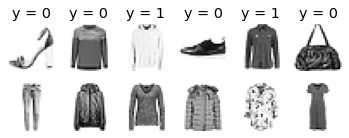

In [396]:
def plot_samples(n_cols = 6):
    
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols, 2))

    for i in range(n_cols):
        
        top, bottom = ax[0][i], ax[1][i]
        top.axis('off'), bottom.axis('off')
        top.set_title("y = {}".format(y_train[i]))
        

        image_1, image_2 = X_train[i]
        top.imshow(image_1, cmap='Greys')
        bottom.imshow(image_2, cmap='Greys')


plot_samples()

###### Contrastive loss function

The loss function $L$ used to update the weights in our model
is defined as follows

$\\ L_{contrastive} = (1 - Y)\dfrac{1}{2}(D)^2 + (Y)\dfrac{1}{2}max(0, D_W) $

The **distance** $D$ is a learnable metric used to compute the
disparity between $x_i, x_j$, computed by the final layer's lambda function.


In [377]:
def ContrastiveLoss(margin=1.0):
    def contrastive_loss(y_true, y_pred):
        pred_squared = K.square(y_pred)
        y_true = tf.cast(y_true, dtype=tf.float32)
        margin_squared = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * pred_squared + (1 - y_true) * margin_squared)
    return contrastive_loss

###### Train model

In [400]:
# Final data form for training/validation
X_train_pairs = [X_train[:,0], X_train[:,1]]
validation_data = ([X_validation[:,0], 
                    X_validation[:,1]], 
                   y_validation)

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss=ContrastiveLoss(margin=1.0))

# Train
history = model.fit(X_train_pairs, 
                    y_train,
                    epochs=2, 
                    batch_size=16,
                    validation_data=validation_data)

Epoch 1/2
6084/6084 [==============================] - 18s 3ms/step - loss: 0.0989 - val_loss: 0.3971
Epoch 2/2
6084/6084 [==============================] - 17s 3ms/step - loss: 0.0970 - val_loss: 0.4438


In [403]:
picture_similarities = model.predict([X_test[:,0], X_test[:,1]])
picture_similarities

array([[6.7252856e-01],
       [1.1268544e-01],
       [1.1803794e+00],
       ...,
       [3.1622776e-04],
       [6.6766447e-01],
       [1.5219867e-02]], dtype=float32)

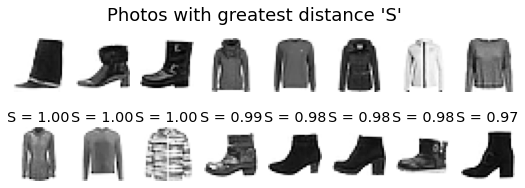

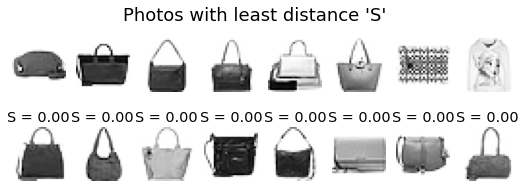

In [432]:
def plot_similar_photos(title, n_cols = 8, reverse=True):

    sim = [x[0] for x in picture_similarities]
    sort_asc = sorted(zip(sim, X_test), key=lambda x:x[0], reverse=reverse)  
    similarities = np.array([pair[0] for pair in sort_asc])
    similarities = (similarities - similarities.min()) / similarities.max() 
    
    photos = [pair[1] for pair in sort_asc]
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols+1, 3))

    for i in range(n_cols):
        
        top, bottom = ax[0][i], ax[1][i]
        top.axis('off'), bottom.axis('off')
        bottom.set_title(f"S = {similarities[i]:.2f}")

        image_1, image_2 = photos[i]
        top.imshow(image_1, cmap='Greys')
        bottom.imshow(image_2, cmap='Greys')

    plt.suptitle(title, fontsize=18)
    plt.show()

plot_similar_photos("Photos with greatest distance 'S'", reverse=True)
plot_similar_photos("Photos with least distance 'S'", reverse=False)

### Conclusion

Now that the method has been demonstrated, to get more accurate results
one might add to the base network in order to further reduce loss.

The lack of convolutions/pooling layers in the base network
probably means that there's little use for this architechture 
outside of toy use cases, but made training fairly quick on CPU-only machine.